In [3]:
%load_ext autoreload
%autoreload 2
from corr_study.datasetApi import *
from corr_study.correlation import *
from corr_study.voxels import *
from matplotlib import pyplot as plt

dataset = Dataset("corr_study/dataset/")

route = dataset.get_routes_TLC()[0]
# ids = dataset.get_ids_CV(Town.T1, Weather.Clear, Time.Sunset, Sensor.LT)

# pcd_top = dataset.open_sample_CV(Town.T1, Weather.Clear, Time.Night, Sensor.LT, ids[0]) 
# pcd_front_left = dataset.open_sample_CV(Town.T1, Weather.Clear, Time.Night, Sensor.LFL, ids[0]) 
# pcd_front_rigth = dataset.open_sample_CV(Town.T1, Weather.Clear, Time.Night, Sensor.LFR, ids[0]) 
# cam_front = dataset.open_measurement_sample_TLC(route, Weather.Clear, Time.Noon, Sensor.CF, 10)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
center_mass_corr = []
for i in range(1, 101):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    center_mass_corr.append(pcd_top.compare_using_voxels(pcd_top_compare, 0.5))

In [7]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
v_top = pcd_top.voxelize(0.5)
corr = []
for i in range(1, 101):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    corr.append(v_top.compute_correlation(pcd_top_compare.voxelize(0.5, v_top.boundaries)))


In [8]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
v_top = pcd_top.voxelize(0.5)
cross_corr = []
for i in range(1, 101, 1):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    cross_corr.append(v_top.compute_correlation_inferring_offset(pcd_top_compare.voxelize(0.5, v_top.boundaries)))

In [9]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
center_mass_corr_weighted = []
for i in range(1, 101):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    center_mass_corr_weighted.append(pcd_top.compare_using_voxels(pcd_top_compare, 0.5, weighted=True))

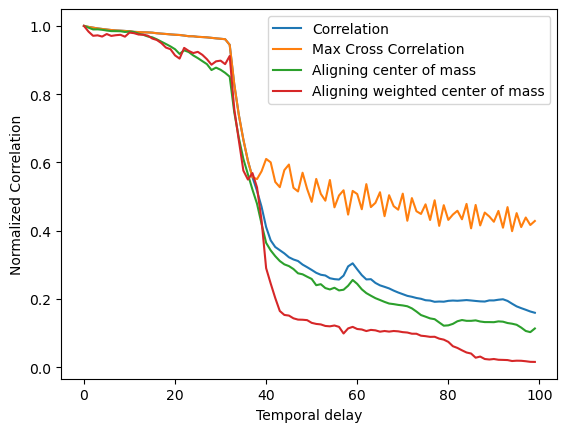

In [10]:
fig, ax = plt.subplots(1,1)
c, = ax.plot(corr)
cc, = ax.plot(cross_corr)
cm, = ax.plot(center_mass_corr)
cmw, = ax.plot(center_mass_corr_weighted)
ax.legend([c, cc, cm, cmw], ["Correlation", "Max Cross Correlation", "Aligning center of mass", "Aligning weighted center of mass"])
plt.ylabel("Normalized Correlation")
plt.xlabel("Temporal delay")
plt.show()

In [30]:
dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 32).visualize()
dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 35).visualize()

In [3]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
mse_mass_center = []
for i in range(1, 101):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    mse_mass_center.append(pcd_top.compare_using_clusters(pcd_top_compare, 10))


In [4]:
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)
mse_mass_center_w = []
for i in range(1, 101):
    pcd_top_compare = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, i)
    mse_mass_center_w.append(pcd_top.compare_using_clusters(pcd_top_compare, 10, weighted=True))


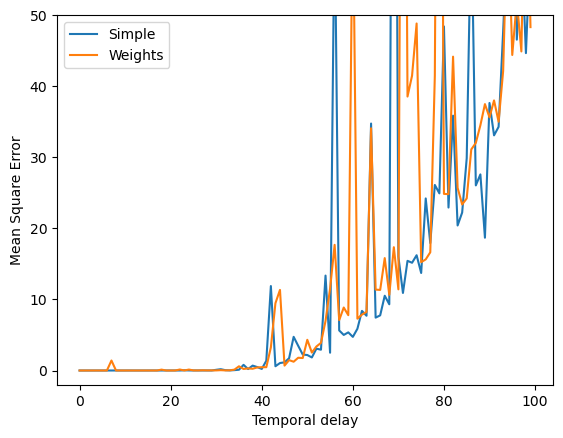

In [5]:
fig, ax = plt.subplots(1,1)
s, = ax.plot(mse_mass_center)
w, = ax.plot(mse_mass_center_w)
ax.legend([s, w], ["Simple", "Weights"])
plt.ylabel("Mean Square Error")
plt.xlabel("Temporal delay")
ax.set_ylim([-2,50])
plt.show()

In [34]:
from sklearn.cluster import DBSCAN
pcd_top = dataset.open_measurement_sample_TLC("00000000_000000", Weather.Clear, Time.Sunset, Sensor.LT, 1)

def compute_oddly_normalized_distance_pairwise(x, y):
    print(np.sqrt(np.sum((x - y)**2) / (np.sum(x**2) * np.sum(y**2))))
    return np.sqrt(np.sum((x - y)**2) / (np.sum(x**2) * np.sum(y**2)))
# clustering = DBSCAN(eps=1, min_samples=10, metric=compute_oddly_normalized_distance_pairwise).fit(pcd_top.data[:,:20])
# clusters = SelmaPointCloud(pcd_top.data, clustering.labels_)
# clusters.visualize()
def compute_oddly_normalized_distance_unilateral(x, y):
    return np.sqrt(np.sum((x - y)**2, axis=1) / np.sqrt(np.sum(x**2, axis=1) * np.sum(y**2)))

In [10]:
compute_oddly_normalized_distance_unilateral(np.array([[1,2,3],[4,5,6]]), np.array([[1,2,3]]))

array([0.        , 0.15826049])

In [13]:
def compute_oddly_normalized_distance(points):
    dists_matrix = np.sqrt(np.sum((points[:, np.newaxis] - points) ** 2, axis=-1))
    distances = np.sqrt(np.sum(points ** 2, axis=1))
    distances = distances[:, np.newaxis]* distances
    return dists_matrix/distances

clustering = DBSCAN(eps=0.001, min_samples=10, metric="precomputed").fit(compute_oddly_normalized_distance(pcd_top.data[15000:30000,:]))
clusters = SelmaPointCloud(pcd_top.data[15000:30000,:], clustering.labels_)
clusters.visualize()

In [47]:
from tqdm import trange
def my_dbscan(data, eps, min_samples):
    def expand_cluster(data, labels, point_idx, cluster_id, eps, min_samples):
        seeds_idxs = np.where(compute_oddly_normalized_distance_unilateral(data, data[point_idx,:]) < eps)[0]
        if len(seeds_idxs) < min_samples:
            labels[point_idx] = -1
            return False
        else:
            labels[seeds_idxs] = cluster_id
            seeds_idxs = np.delete(seeds_idxs, np.where(seeds_idxs == point_idx))
            while len(seeds_idxs) != 0:
                current_idx = seeds_idxs[0]
                results_idxs = np.where(compute_oddly_normalized_distance_unilateral(data, data[current_idx,:]) < eps)[0]
                if len(results_idxs) >= min_samples:
                    for index in results_idxs:
                        if labels[index] < 0:
                            if labels[index] == -2:
                                seeds_idxs = np.append(seeds_idxs, index)
                            labels[index] = cluster_id
                seeds_idxs = np.delete(seeds_idxs, np.where(seeds_idxs == current_idx))
            return True


    cluster_id = 0
    labels = np.zeros(data.shape[0]) - 2
    for i in trange(data.shape[0]):
        if labels[i] == -2:
            if expand_cluster(data, labels, i, cluster_id, eps, min_samples):
                cluster_id += 1
    return labels

out = my_dbscan(pcd_top.data, 0.05, 100)

100%|██████████| 91718/91718 [02:54<00:00, 525.77it/s] 


In [29]:
print(out.astype(int))

[-1 -1 -1 ... -1 -1 -1]


In [48]:
SelmaPointCloud(pcd_top.data, ground_truth=out.astype(int)).visualize()

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make conte

In [39]:
compute_oddly_normalized_distance_unilateral(pcd_top.data, pcd_top.data[1,:]).std()

1.8310907